### Autoencoders with keras example
#### Tutorial from https://blog.keras.io/building-autoencoders-in-keras.html


In [11]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [3]:
# Load MNIST dataset
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [5]:
# Train the autoencoder for 50 epochs.
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
60000/60000 [==============================] - 2s 36us/sample - loss: 0.6952 - val_loss: 0.6951
Epoch 2/50
60000/60000 [==============================] - 2s 26us/sample - loss: 0.6950 - val_loss: 0.6949
Epoch 3/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.6948 - val_loss: 0.6947
Epoch 4/50
60000/60000 [==============================] - 2s 26us/sample - loss: 0.6945 - val_loss: 0.6945
Epoch 5/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.6943 - val_loss: 0.6942
Epoch 6/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.6941 - val_loss: 0.6940
Epoch 7/50
60000/60000 [==============================] - 2s 26us/sample - loss: 0.6939 - val_loss: 0.6938
Epoch 8/50
60000/60000 [==============================] - 2s 30us/sample - loss: 0.6937 - val_loss: 0.6936


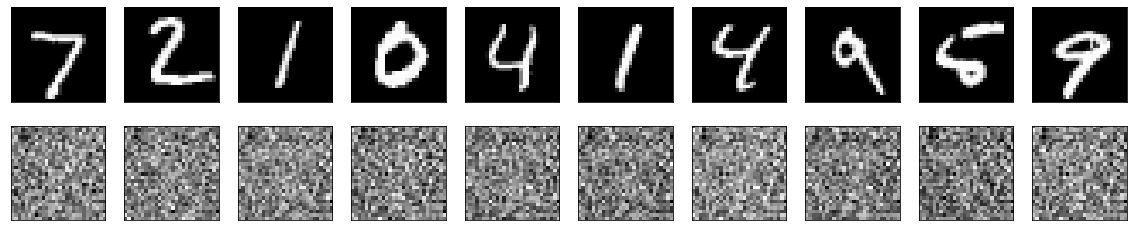

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
encoded_imgs.shape

(10000, 32)

____________________
### Example from: https://medium.com/red-buffer/autoencoders-guide-and-code-in-tensorflow-2-0-a4101571ce56

In [8]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [19]:
from tensorflow.keras.layers import Flatten

class FullyConnectedAutoEncoder(Model):
    def __init__(self):
        super(FullyConnectedAutoEncoder, self).__init__()
        self.flatten_layer = Flatten()
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        
        
        self.bottleneck = Dense(16, activation='relu')
    
        self.dense4 = Dense(32, activation='relu')
        self.dense5 = Dense(64, activation='relu')
        
        self.dense_final = Dense(784)
        
    
    def call(self, inp):
        x_reshaped = self.flatten_layer(inp)
        x = self.dense1(x_reshaped)
        x = self.dense2(x)
        x = self.bottleneck(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense_final(x)
        return x, x_reshaped

In [76]:
import tensorflow as tf

def loss(x, x_bar):
    return tf.losses.mean_squared_error(x, x_bar)

def grad(model, inputs):
    with tf.GradientTape() as tape:
        reconstruction, inputs_reshaped = model(inputs)
        loss_value = loss(inputs_reshaped, reconstruction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), inputs_reshaped, reconstruction

def train_model(model):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    global_step = Variable(0)
    num_epochs = 5
    batch_size = 400

    for epoch in range(num_epochs):
        print("Epoch: ", epoch)
        for x in range(0, len(x_train), batch_size):
            x_inp = x_train[x : x + batch_size]
            loss_value, grads, inputs_reshaped, reconstruction = grad(model, x_inp)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        print("Step: {},Loss: {}".format(epoch, loss(inputs_reshaped, reconstruction).numpy()))
        
def plot_predictions(models):
    predictions = []
    for m in models:
        predictions.append(np.array(m.predict(x_test)[0]))
    n = 10  # how many digits we will display
    rows = len(models) # how many rows to plot = number of models
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(rows+1, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for idx,p in enumerate(predictions):
            ax = plt.subplot(rows+1, n, i + 1 + (idx+1)*n)
            plt.imshow(p[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

plt.show()

In [27]:
from tensorflow import Variable

model = FullyConnectedAutoEncoder()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

global_step = Variable(0)
num_epochs = 5
batch_size = 400

for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    for x in range(0, len(x_train), batch_size):
        x_inp = x_train[x : x + batch_size]
        loss_value, grads, inputs_reshaped, reconstruction = grad(model, x_inp)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
    print("Step: {},Loss: {}".format(epoch, loss(inputs_reshaped, reconstruction).numpy()))

Epoch:  0
Step: 0,Loss: [0.05516481 0.0538431  0.03719277 0.0722165  0.03291824 0.07266439
 0.02491412 0.0455111  0.06977171 0.06184086 0.05412272 0.05451309
 0.05596528 0.04567328 0.03599786 0.05316624 0.02558533 0.05791623
 0.04871461 0.03314853 0.04630417 0.05535611 0.06393795 0.05238956
 0.04730892 0.02307966 0.04643617 0.06714911 0.06893849 0.03977259
 0.0437421  0.04644827 0.0396676  0.0329865  0.03112987 0.05392647
 0.0484722  0.05423652 0.04389761 0.04234386 0.04979698 0.05284144
 0.0542076  0.05989968 0.03547091 0.04786873 0.05916642 0.04406864
 0.05568331 0.05755344 0.038655   0.05526482 0.07095887 0.03365558
 0.04487131 0.06892338 0.0428795  0.0881175  0.06496087 0.05071153
 0.04186329 0.04123746 0.03401049 0.04919885 0.05399131 0.03392317
 0.05624879 0.04764765 0.03953824 0.09189007 0.06468042 0.01765054
 0.07133958 0.05064692 0.05521628 0.06834323 0.0524169  0.07328794
 0.05560039 0.05438285 0.06544846 0.06748152 0.04855421 0.05650758
 0.06897591 0.05161991 0.03007707 0.04

In [29]:
model.summary()

Model: "fully_connected_auto_encoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
dense_20 (Dense)             multiple                  50240     
_________________________________________________________________
dense_21 (Dense)             multiple                  2080      
_________________________________________________________________
dense_22 (Dense)             multiple                  528       
_________________________________________________________________
dense_23 (Dense)             multiple                  544       
_________________________________________________________________
dense_24 (Dense)             multiple                  2112      
_________________________________________________________________
dense_25 (Dense)             multipl

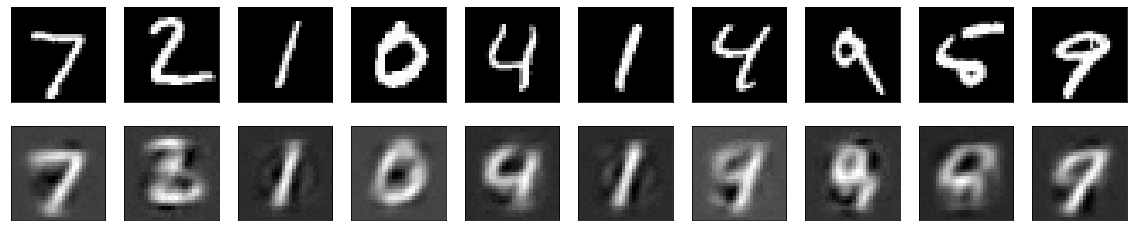

In [46]:
# Trained for 5 epochs, we plot the results
import matplotlib.pyplot as plt
predictions = model.predict(x_test)
predictions = np.array(predictions[0])

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()


In [49]:
# Now we train for more epochs
model = FullyConnectedAutoEncoder()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

global_step = Variable(0)
num_epochs = 50
batch_size = 400

for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    for x in range(0, len(x_train), batch_size):
        x_inp = x_train[x : x + batch_size]
        loss_value, grads, inputs_reshaped, reconstruction = grad(model, x_inp)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
    print("Step: {},Loss: {}".format(epoch, sum(loss(inputs_reshaped, reconstruction)/batch_size).numpy()))

Epoch:  0
Step: 0,Loss: 0.04921848699450493
Epoch:  1
Step: 1,Loss: 0.03788404166698456
Epoch:  2
Step: 2,Loss: 0.0346350260078907
Epoch:  3
Step: 3,Loss: 0.03304200991988182
Epoch:  4
Step: 4,Loss: 0.03207230567932129
Epoch:  5
Step: 5,Loss: 0.03130551800131798
Epoch:  6
Step: 6,Loss: 0.030752677470445633
Epoch:  7
Step: 7,Loss: 0.03028387576341629
Epoch:  8
Step: 8,Loss: 0.029863761737942696
Epoch:  9
Step: 9,Loss: 0.029486913233995438
Epoch:  10
Step: 10,Loss: 0.029140936210751534
Epoch:  11
Step: 11,Loss: 0.028849992901086807
Epoch:  12
Step: 12,Loss: 0.028619077056646347
Epoch:  13
Step: 13,Loss: 0.028406383469700813
Epoch:  14
Step: 14,Loss: 0.02822144888341427
Epoch:  15
Step: 15,Loss: 0.02805977873504162
Epoch:  16
Step: 16,Loss: 0.02788795530796051
Epoch:  17
Step: 17,Loss: 0.027725225314497948
Epoch:  18
Step: 18,Loss: 0.02759157493710518
Epoch:  19
Step: 19,Loss: 0.02746468037366867
Epoch:  20
Step: 20,Loss: 0.027346819639205933
Epoch:  21
Step: 21,Loss: 0.027241604402661324

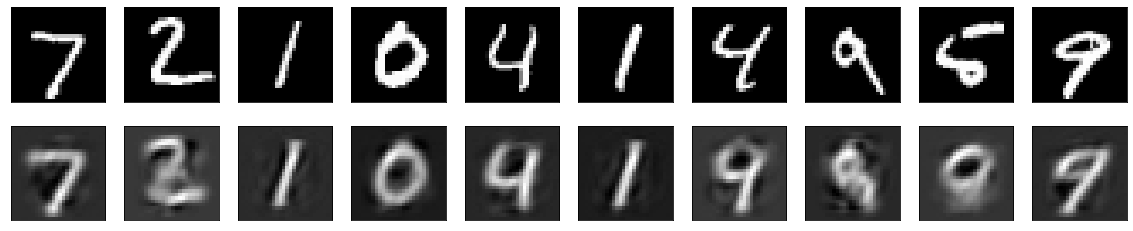

In [50]:
predictions = model.predict(x_test)
predictions = np.array(predictions[0])

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [61]:
# Create an autoencoder with higher representation space.
class FullyConnectedAutoEncoder2(Model):
    def __init__(self):
        super(FullyConnectedAutoEncoder2, self).__init__()
        self.flatten_layer = Flatten()
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        
        self.bottleneck = Dense(32, activation='relu')
    
        self.dense4 = Dense(32, activation='relu')
        self.dense5 = Dense(64, activation='relu')
        
        self.dense_final = Dense(784)
        
    def call(self, inp):
        x_reshaped = self.flatten_layer(inp)
        x = self.dense1(x_reshaped)
        x = self.dense2(x)
        x = self.bottleneck(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense_final(x)
        return x, x_reshaped

In [64]:
# We train the new model
model2 = FullyConnectedAutoEncoder2()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

global_step = Variable(0)
num_epochs = 10
batch_size = 400

for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    for x in range(0, len(x_train), batch_size):
        x_inp = x_train[x : x + batch_size]
        loss_value, grads, inputs_reshaped, reconstruction = grad(model2, x_inp)
        optimizer.apply_gradients(zip(grads, model2.trainable_variables))
        
    print("Step: {},Loss: {}".format(epoch, sum(loss(inputs_reshaped, reconstruction)/batch_size).numpy()))

Epoch:  0
Step: 0,Loss: 0.04062925651669502
Epoch:  1
Step: 1,Loss: 0.03072342276573181
Epoch:  2
Step: 2,Loss: 0.02734043449163437
Epoch:  3
Step: 3,Loss: 0.025500133633613586
Epoch:  4
Step: 4,Loss: 0.024704379960894585
Epoch:  5
Step: 5,Loss: 0.023997178301215172
Epoch:  6
Step: 6,Loss: 0.02356731705367565
Epoch:  7
Step: 7,Loss: 0.023335587233304977
Epoch:  8
Step: 8,Loss: 0.02316155470907688
Epoch:  9
Step: 9,Loss: 0.02293182536959648


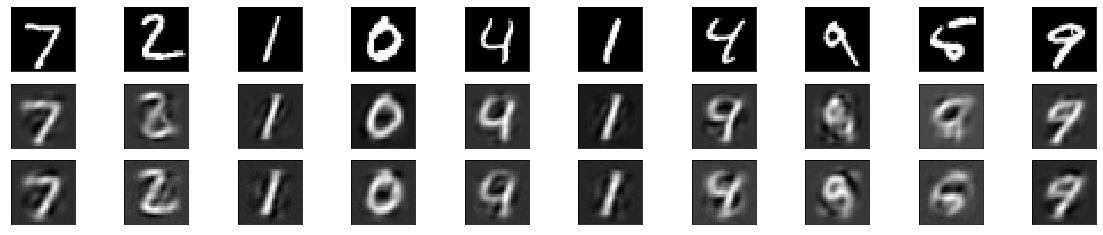

In [77]:
models = [model, model2]

plot_predictions(models)

In [66]:
# Create an autoencoder with even higher representation space.
class FullyConnectedAutoEncoder3(Model):
    def __init__(self):
        super(FullyConnectedAutoEncoder3, self).__init__()
        self.flatten_layer = Flatten()
        self.dense1 = Dense(256, activation='relu')
        self.dense2 = Dense(128, activation='relu')
        
        self.bottleneck = Dense(128, activation='relu')
    
        self.dense4 = Dense(128, activation='relu')
        self.dense5 = Dense(256, activation='relu')
        
        self.dense_final = Dense(784)
        
    def call(self, inp):
        x_reshaped = self.flatten_layer(inp)
        x = self.dense1(x_reshaped)
        x = self.dense2(x)
        x = self.bottleneck(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense_final(x)
        return x, x_reshaped

In [ ]:
# We train the new model
model3 = FullyConnectedAutoEncoder3()
train_model(model3)




In [71]:
models = [model, model2]
len(models)

2